# Sara och Marcus Uppgift 1

# 3.1 Kontinuerlig optimering

In [248]:
from numpy import e, arctan, cos, sin, ones
import pyswarms as ps


def cal_function_value(values: list, minimum=True) -> list:
    """Calculate the function value for all the solutions in the swarm."""
    calculations = []
    for pair in values:
        x, y = pair
        if minimum:
            calculations.append(function(x, y))
        else:
        # If we want to find the maximum for the function we change the sign of the return value
            calculations.append(-function(x, y))
    return calculations


def function(x: float, y: float) -> float:
    """Definition of the function"""
    return (e ** (-0.05 * (x ** 2 + y ** 2))) * ((arctan(x) - arctan(y)) + (e ** - (x ** 2 + y ** 2)) * (cos(x) ** 2 * sin(y)) ** 2)


def pso():
    """Create one optimizer for minimum and one for maximum. Find them and print the result."""
    options = {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
    bounds = (-5*ones(2), 5*ones(2))

    # Optimizer for minimum
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=2, options=options, bounds=bounds)
    minimum, pos_minimum = optimizer.optimize(cal_function_value, 1000, verbose=False)

    # Optimizer for maximum
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=2, options=options, bounds=bounds)
    # The value that is stored in the maximum variable is negative, since we changed its sign in the calculation
    maximum, pos_maximum = optimizer.optimize(cal_function_value, 1000, verbose=False, minimum=False)

    print(f'The minimum for the function is {minimum}, coordinates {pos_minimum}')
    print(f'The maximum for the function is {-maximum}, coordinates {pos_maximum}')

In [249]:
pso()

The minimum for the function is -1.5697840913957708, coordinates [-1.52257708  1.52256797]
The maximum for the function is 1.569784174244423, coordinates [ 1.52255974 -1.52256888]


# 3.2 TSP datainsamling och preprocessing

In [3]:
from sko.ACA import ACA_TSP
from math import sin, asin, cos, sqrt, atan2, radians
import regex as re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import numpy as np
import matplotlib.pyplot as plt
import random


def get_data():
    # Scrapes the data 
    options = webdriver.ChromeOptions()
    options.add_argument("headless")
    driver = webdriver.Chrome('./chromedriver', options = options)

    driver.get("https://www.infoplease.com/world/geography/major-cities-latitude-longitude-and-corresponding-time-zones")
    elem = driver.find_element_by_id("A0001770")
    text = elem.text
    driver.close()
    return text

def get_cities(data: str):
    # Formats the data into a more convenient lookup table
    rows = data.split('\n')
    cities = []
    for row in rows[2:]:
        city = re.findall('[A-Za-z]*, [A-Za-z]*', row)
        latitude, longitude = re.findall('[0-9]{1,} [0-9]{1,} [SNWE]', row)
        cities.append({'city': city, 
                       'latitude': latitude, 
                       'longitude': longitude})
    return cities

def to_degrees(city: dict):
    # Converts the lat and long coordinates to decimal degrees, returns them in radians
    dms_to_deg = lambda deg, minutes, direction: (float(deg) + float(minutes)/60) * (-1 if direction in ['W', 'S'] else 1)
    
    latitude = city['latitude']
    longitude = city['longitude']

    lat = dms_to_deg(*re.split('[ ]', latitude))
    long = dms_to_deg(*re.split('[ ]', longitude))

    return radians(lat), radians(long)

def calc_d(city1: dict, city2: dict):
    # calculates the distance between two coordinates
    lat1, lon1 = to_degrees(city1)
    lat2, lon2 = to_degrees(city2)
    
    R = 6372.8 # km

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (sin(dlat/2)**2) + (cos(lat1) * cos(lat2) * (sin(dlon/2)**2))
    c = 2 * asin(sqrt(a)) 
    
    distance = R * c
    return distance # km

def get_distance_matrix(cities: list):
    # Generates a distance matrix from a list of cities with coordinates
    index_matrix = [[(i, j) for j in range(len(cities))] for i in range(len(cities))]
    distance_matrix = [[calc_d(cities[i_tup[0]], cities[i_tup[1]]) for i_tup in row] for row in index_matrix]
    return np.array([np.array(row) for row in distance_matrix])

def cal_total_distance(routine: list):
    # Calculates the total distance of a given routine
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

In [5]:
data = get_data()
cities = get_cities(data)
distance_matrix = get_distance_matrix(cities)

/var/folders/01/_wv7n9yj3gndbty36gzv6wk00000gn/T/ipykernel_1104/4013058821.py:16: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver', options = options)
/var/folders/01/_wv7n9yj3gndbty36gzv6wk00000gn/T/ipykernel_1104/4013058821.py:19: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_id("A0001770")


# 3.3 Baseline 1

In [230]:
routines = [np.array([i for i in range(120)]) for j in range(100000)]
for routine in routines:
    np.random.shuffle(routine)

distances = [cal_total_distance(routine) for routine in routines]

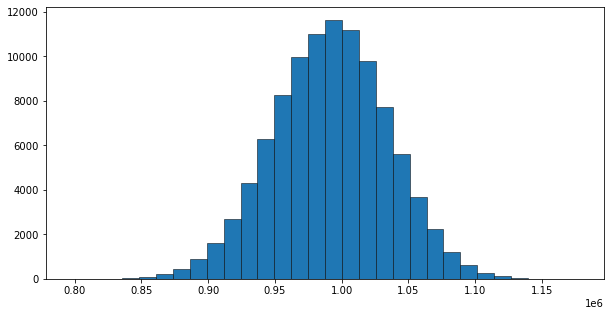

In [231]:
plt.figure(figsize=(10, 5))
plt.hist(distances, bins = 30, edgecolor='black', linewidth=0.5)
plt.show()

# 3.4 Baseline 2

In [232]:
not_visited = list(range(120))
visited = []
total_distance = 0
current_position = random.randint(0, 120)

for _ in range(len(distance_matrix)):
    # Position is a variable used to keep track of which of the nearest cities we will try next
    position = 1
    nearest_found = False
    # Array with all the distances for the current city
    distances = distance_matrix[current_position]
    while not nearest_found:
        # We look at the city at index 1, since index 0 is the current city
        distance_to_nearest_city = np.sort(distances)[position]
        nearest_city = np.where(distances == distance_to_nearest_city)[0][0]
        position += 1
        # Let's check if we've already visited this city, if not let's go there.
        # Otherwise we take the next nearest city. 
        if nearest_city in not_visited:
            # We found the nearest city that we haven't visited yet. Let's go!
            current_position = nearest_city
            not_visited.remove(current_position)
            visited.append(current_position)
            total_distance += distance_to_nearest_city
            nearest_found = True

print(f'\nRoutine: {visited}\n\nDistance: {round(total_distance)}km')


Routine: [83, 99, 113, 75, 119, 78, 95, 115, 24, 13, 106, 23, 86, 4, 6, 112, 2, 9, 70, 66, 91, 22, 3, 19, 47, 14, 34, 88, 107, 50, 102, 77, 117, 42, 65, 15, 21, 93, 64, 68, 61, 85, 41, 44, 12, 39, 0, 97, 48, 18, 67, 63, 36, 100, 98, 103, 5, 35, 25, 76, 101, 53, 60, 62, 46, 16, 89, 57, 49, 45, 114, 74, 71, 32, 30, 43, 90, 31, 11, 58, 81, 38, 72, 26, 110, 84, 17, 27, 96, 8, 59, 105, 55, 37, 94, 20, 108, 73, 51, 1, 92, 69, 52, 28, 33, 82, 104, 79, 87, 80, 111, 116, 10, 54, 109, 40, 56, 29, 118, 7]

Distance: 132868km


# 3.5 Baseline 3

In [90]:
import multiprocess
import time
import itertools
from sko.GA import GA_TSP

def run_GA_TSP(setting: list):
    max_iter = setting[0]
    prob_mut = setting[1]
    size_pop = setting[2]

    ga_tsp = GA_TSP(func=cal_total_distance, n_dim=120, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut)
    best_points, best_distance = ga_tsp.run()
    return best_points, best_distance

def run(setting):
    max_iter, prob_mut, pop_size = setting[0], setting[1], setting[2]
        
    n_cores = multiprocess.cpu_count()
    
    
    start_mp = time.time()
    pool = multiprocess.Pool(processes = n_cores)
    ncore_settings = [setting for i in range(n_cores)]
    result = pool.map(run_GA_TSP, ncore_settings)
    end_mp = time.time()
    
    start_seq = time.time()
    
    for i in range(n_cores):
        best_x, best_y = run_GA_TSP(setting)
    
    end_seq = time.time()
    
    mp_time = end_mp-start_mp
    seq_time = end_seq-start_seq
        
    print(f'Population size: {pop_size}\n\nMax iterations: {max_iter} \n\nMutation probability: {prob_mut}\n')
    print(f'With multiprocessing ({n_cores} cores) finished in {round(mp_time, 2)} seconds\n')
    print(f'Without multiprocessing finished in {round(seq_time, 2)} seconds\n')
    print('-'*30)
    

In [92]:
all_settings = list(itertools.product([100, 500, 1000], [0.001, 0.01, 0.05]))
all_settings = list(map(list, all_settings))
all_settings = [setting + [40] for setting in all_settings]

for setting in all_settings:
    run(setting)

Population size: 40

Max iterations: 100 

Mutation probability: 0.001

With multiprocessing (8 cores) finished in 1.19 seconds

Without multiprocessing finished in 5.11 seconds

------------------------------
Population size: 40

Max iterations: 100 

Mutation probability: 0.01

With multiprocessing (8 cores) finished in 1.19 seconds

Without multiprocessing finished in 5.16 seconds

------------------------------
Population size: 40

Max iterations: 100 

Mutation probability: 0.05

With multiprocessing (8 cores) finished in 1.13 seconds

Without multiprocessing finished in 5.16 seconds

------------------------------
Population size: 40

Max iterations: 500 

Mutation probability: 0.001

With multiprocessing (8 cores) finished in 5.47 seconds

Without multiprocessing finished in 25.71 seconds

------------------------------
Population size: 40

Max iterations: 500 

Mutation probability: 0.01

With multiprocessing (8 cores) finished in 5.53 seconds

Without multiprocessing finished 

# 3.6 Ant Colony Optimization

In [17]:
data = get_data()
cities = get_cities(data)
distance_matrix = get_distance_matrix(cities)

In [247]:
num_points = len(cities)
size_pop = 50
max_iters = [100, 250, 500]

for max_iter in max_iters:
    start = time.time()
    aca = ACA_TSP(func=cal_total_distance, 
                  n_dim=num_points,
                  size_pop=size_pop, max_iter=max_iter,
                  distance_matrix=distance_matrix)

    best_x, best_y = aca.run()
    stop = time.time()

    time_elapsed = stop-start
    print(f'\nRoutine: {best_x}\n\nDistance: {round(best_y)}km\n\nTime: {round(time_elapsed/60, 2)} min\n\nPopulation size: {size_pop}\n\nMax iterations: {max_iter}\n')
    print('-'*20)


Routine: [  0  44  41  85  61  68  64  15  21  65   3  22  91   9  70  66 119  75
 113  78  95 115  24  13  23 106  83  99 112   6   4   2  63  67  18  39
  12  34  19  47  14  42  93  88 107  50 102  77  86 117  97  48  54 116
  87  80 111  79  69  52  28  26  72  38  81 109   8  96  27  84  17 110
 104  82  10  33 105  59  55  37  94   1  73  51 118   7  20 108  92 101
  35  76  25 103  98 100  11  31  90  43  30  57  49  45  71  32  74 114
  89  16  46  62  60  53   5  36  58  29  40  56]

Distance: 163735km

Time: 0.48 min

Population size: 50

Max iterations: 100

--------------------

Routine: [  0  41  44  12  39  64  68  61  85  15  21  93  65  22   3  19  47  14
  95  42  34  88 107  50 102  77 117 115  24  13 106  23  86   4   6 112
  83  99 113  75 119  78  66  70   9  18  91  63  67   2  36  11  31  90
  43  30  16  89  57  49  45 114  74  71  32  46  62  60  53  35 101  25
  76   5 103  98 100  29  40  56 109  38  81  58  26  72 110  84  17  27
  96   8  59 105  55  92   